# Yellin Limits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import expon, norm, uniform, gamma
from scipy import stats
from itertools import product
import numba as nb
from scipy.optimize import fsolve, bisect, minimize
from PIL import Image, ImageDraw
import matplotlib as mpl
from tqdm.auto import tqdm, trange
%config InlineBackend.figure_formats = ['svg']

In [2]:
fontsize = 12

mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

Load the data.

In [3]:
NAMES = ['A', 'B', 'C']
EXPOSURE = np.array([7, 5, 100])
COUNTS = np.array([2100, 1000, 2000])
THRESHOLD_LOW = np.array([0.1, 0.035, 1])
THRESHOLD_UP = np.array([20, 10, 400])
RESOLUTION = np.array([0.015, 0.005, 0.15])
EFFICIENCY = np.array([0.8, 0.65, 0.5])
NMBR_REPETITIONS = 10

In [4]:
data_alice = []
data_bob = []
data_carol = []

for i in range(NMBR_REPETITIONS):
    data_alice.append(np.loadtxt('data/alice/data_alice_{}.txt'.format(i)))
    data_bob.append(np.loadtxt('data/bob/data_bob_{}.txt'.format(i)))
    data_carol.append(np.loadtxt('data/carol/data_carol_{}.txt'.format(i)))
    
grids = []
efficiencies = []

grids.append(np.loadtxt('data/alice/efficiency_alice.txt')[:,0])
grids.append(np.loadtxt('data/bob/efficiency_bob.txt')[:,0])
grids.append(np.loadtxt('data/carol/efficiency_carol.txt')[:,0])

efficiencies.append(np.loadtxt('data/alice/efficiency_alice.txt')[:,1])
efficiencies.append(np.loadtxt('data/bob/efficiency_bob.txt')[:,1])
efficiencies.append(np.loadtxt('data/carol/efficiency_carol.txt')[:,1])

data_alice = np.array(data_alice)
data_bob = np.array(data_bob)
data_carol = np.array(data_carol)
grids = np.array(grids)
efficiencies = np.array(efficiencies)

## Exclusion limits with Yellin

We will now proceed and calculate combined limits for above experiments. Limits are calculated with Yellins Maximum Gap method, and a likelihood approach.

We create objects for our expected signal models, which are needed for the calculation of limits.

In [5]:
def sig(x, args, grid, efficiency, exposure):  # assumes equidistant grid of efficiency
    """
    TODO
    """
    
    scale = args[0]
    
    signal_model = np.cumsum(expon.pdf(grid, scale=scale) * efficiency)*(grid[1] - grid[0])
    retval = np.interp(x, grid, signal_model) * exposure
    
    return retval

def sig_combined(x:list, args: list, grids: list, efficiencies: list, exposures: list):
    """
    TODO
    """
    
    assert len(grids) == len(efficiencies) == len(exposures), 'The lists must have same length!'
    
    scale = args[0]
    
    retval = 0
    
    for i in range(len(efficiencies)):
        signal_model = np.cumsum(expon.pdf(grids[i], scale=scale) * efficiencies[i])*(grids[i][1] - grids[i][0])
        retval += np.interp(x, grids[i], signal_model) * exposures[i]
    
    return retval

First, we show the steps of a Yellin limit calculation individually. This includes the calculation of the expectations in all gaps. Aferwards, we find the exclusion limit with the expectation in the largest gap.

We calculate for a given signal parameter the number of totally expected signal events in all experiments indivudally, and combined.

In [6]:
LAMB = 1

expectations = []
extended_energies = []
total_expected = []

# individual expectations
data_alice_sorted = np.sort(data_alice[0])
data_bob_sorted = np.sort(data_bob[0])
data_carol_sorted = np.sort(data_carol[0])

for i, data in enumerate([data_alice_sorted, data_bob_sorted, data_carol_sorted]):
    extended_energies.append(np.concatenate(([THRESHOLD_LOW[i]- 2*RESOLUTION[i]], data, [THRESHOLD_UP[i]])))
    cumsignal = sig(x=extended_energies[-1], 
                    args=[LAMB], grid=grids[i], efficiency=efficiencies[i],
                    exposure=EXPOSURE[i])
    expectations.append(np.diff(cumsignal))
    total_expected.append(cumsignal[-1] - cumsignal[0])
    
# combined expectations
for idx, datas in zip([[0,1], [0,2], [1,2], [0,1,2]], 
                      [[data_alice[0], data_bob[0]], [data_alice[0], data_carol[0]], [data_bob[0], data_carol[0]], [data_alice[0], data_bob[0], data_carol[0]]]):
    data = np.sort(np.concatenate(datas, axis=0))
    extended_energies.append(np.concatenate(([np.min(THRESHOLD_LOW[idx]- 2*RESOLUTION[idx])], 
                                             data, 
                                             [np.max(THRESHOLD_UP[idx])])))
    cumsignal = sig_combined(x=extended_energies[-1], 
                             args=[LAMB], 
                             grids=grids[idx], 
                             efficiencies=efficiencies[idx],
                             exposures=EXPOSURE[idx])
    expectations.append(np.diff(cumsignal))
    total_expected.append(cumsignal[-1] - cumsignal[0])


The following cell computes plot of the expectations for several signal parameters, for better visualization of the process.

In [7]:
DPI=150

for j,LAMB in enumerate(np.logspace(-1,1,num=10)):
    
    if LAMB == 0.1:
        print('\n LAMB: {}'.format(LAMB))

    expectations = []
    extended_energies = []
    total_expected = []

    # individual expectations
    data_alice_sorted = np.sort(data_alice[0])
    data_bob_sorted = np.sort(data_bob[0])
    data_carol_sorted = np.sort(data_carol[0])

    for i, data in enumerate([data_alice_sorted, data_bob_sorted, data_carol_sorted]):
        extended_energies.append(np.concatenate(([THRESHOLD_LOW[i]- 2*RESOLUTION[i]], data, [THRESHOLD_UP[i]])))
        cumsignal = sig(x=extended_energies[-1], 
                        args=[LAMB], grid=grids[i], efficiency=efficiencies[i],
                        exposure=EXPOSURE[i])
        expectations.append(np.diff(cumsignal))
        total_expected.append(cumsignal[-1] - cumsignal[0])

    # combined expectations
    for idx, datas in zip([[0,1], [0,2], [1,2], [0,1,2]], 
                          [[data_alice[0], data_bob[0]], [data_alice[0], data_carol[0]], [data_bob[0], data_carol[0]], [data_alice[0], data_bob[0], data_carol[0]]]):
        data = np.sort(np.concatenate(datas, axis=0))
        extended_energies.append(np.concatenate(([np.min(THRESHOLD_LOW[idx]- 2*RESOLUTION[idx])], 
                                                 data, 
                                                 [np.max(THRESHOLD_UP[idx])])))
        cumsignal = sig_combined(x=extended_energies[-1], 
                                 args=[LAMB], 
                                 grids=grids[idx], 
                                 efficiencies=efficiencies[idx],
                                 exposures=EXPOSURE[idx])
        expectations.append(np.diff(cumsignal))
        total_expected.append(cumsignal[-1] - cumsignal[0])


    nam = NAMES.copy()
    nam.append(NAMES[0] + ' and ' + NAMES[1])
    nam.append(NAMES[0] + ' and ' + NAMES[2])
    nam.append(NAMES[1] + ' and ' + NAMES[2])
    
    # plots
    
    lims = {'xlim': [(0,20),(0,10),(0,400),(0,20),(0,400),(0,400)],
           'ylim': [(0,0.3),(0,0.2),(0,18),(0,0.03),(0,2),(0,2)]}

    fig, axes = plt.subplots(2,3,figsize=(10,6), sharey=False)
    for i in range(6):
        if LAMB == 0.1:
            print('Total Expected in {}: {}'.format(nam[i], total_expected[i]))
        axes[int(i/3),i%3].scatter((extended_energies[i][1:] - extended_energies[i][:-1])/2 + extended_energies[i][:-1], 
                    expectations[i], 
                    color='C' + str(i), rasterized=True, s=10, marker='.', label=nam[i])
        axes[int(i/3),i%3].legend(loc='upper right')
        axes[int(i/3),i%3].set_xlim(lims['xlim'][i])
        axes[int(i/3),i%3].set_ylim(lims['ylim'][i])
    fig.supxlabel('Recoil Energy (keV)')
    fig.supylabel('Gap Size (1/$\sigma$)')
    fig.suptitle(f'Signal Paramter $\lambda$: {LAMB:5.2f}')
    plt.tight_layout()
    plt.savefig('plots/gap_size_{}.png'.format(j), dpi=DPI)
    plt.close()

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    nam = NAMES[0] + ' and ' + NAMES[1] + ' and ' + NAMES[2]
    if LAMB == 0.1:
        print('Total Expected in {}: {}'.format(nam, total_expected[6]))
    ax.scatter((extended_energies[6][1:] - extended_energies[6][:-1])/2 + extended_energies[6][:-1], 
                expectations[6], 
                color='C' + str(6), rasterized=True, s=10, marker='.', label=nam)
    ax.legend()
    ax.set_ylim(0,0.4)
    ax.set_xlim(0,400)
    fig.supxlabel('Recoil Energy (keV)')
    fig.supylabel('Gap Size (1/$\sigma$)')
    fig.suptitle(f'Signal Paramter $\lambda$: {LAMB:5.2f}')
    plt.tight_layout()
    plt.savefig('plots/gap_size_all_{}.png'.format(j), dpi=DPI)
    plt.close()


 LAMB: 0.1
Total Expected in A: 2.0792427862478013
Total Expected in B: 2.2917890825088447
Total Expected in C: 0.0057262385641891934
Total Expected in A and B: 4.375221169687032
Total Expected in A and C: 2.086234864261616
Total Expected in B and C: 2.298781163244904
Total Expected in A and B and C: 4.38221325042309


We put the plots together to a GIF. The GIF can be viewed in the folder `plots/`.

In [8]:
images = []

for i in range(10):
    images.append(Image.open('plots/gap_size_{}.png'.format(i)))
    images[0].save('plots/gap_size.gif', format='GIF', save_all=True, append_images=images[1:], duration=300, loop=0)
    
images = []

for i in range(10):
    images.append(Image.open('plots/gap_size_all_{}.png'.format(i)))
    images[0].save('plots/gap_size_all.gif', format='GIF', save_all=True, append_images=images[1:], duration=300, loop=0)

We obtain the 90 % confidence limit on the cross section, which is a linear prefactor on the otherwise fully determined signal model, by solving the implicit equation:

$$ 0.9 = C_{0}(x, \mu)=\sum_{k=0}^{m} \frac{(k x-\mu)^{k} e^{-k x}}{k !}\left(1+\frac{k}{\mu-k x}\right) $$

with mu ... expectation in the whole region,

sigma ... linear prefactor of signal model,

with N ... expected number of events, 

m ... int(mu/x), 

x ... expectation in the gap.

In [9]:
def _C0(mu, x):
    retval = 0
    for k in range(int(mu/x)+1):
        fact = np.math.factorial(k)
        if fact > 0:
            added = (k*x - mu)**k*np.exp(-k*x)*(1 + k/(mu - k*x))
            added /= fact
            if np.isclose(retval + added, retval) or fact > 1e100:  # truncate the sum
                break
            else:
                retval += added
        else:
            pass
    retval = np.maximum(retval,0)
    return retval

vec_C0 = np.vectorize(_C0)

In [10]:
def _solve_impl(f):
    a, b = 1e-2, 1e6 
    return bisect(f, a, b)

We calcualte the limits for a given signal parameter, for all combinations of experiments.

In [11]:
LAMB = 1

print('Signal Parameter: ', LAMB)

print('\n>>> Individual Limits')

for i in range(3):
    limit = _solve_impl(lambda sigma: _C0(mu=sigma*total_expected[i], x=sigma*np.max(expectations[i])) - 0.9)
    print('Limit {}: {}'.format(NAMES[i], limit))

# combined 

print('\n>>> Combined Limits')
    
for n, (i,j) in enumerate([(0,1), (0,2), (1,2)]):
    limit = _solve_impl(lambda sigma: _C0(mu=sigma*total_expected[n+3], x=sigma*np.max(expectations[n+3])) - 0.9)
    print('{}: {}'.format(NAMES[i] + ' and ' + NAMES[j], limit))
    
limit = _solve_impl(lambda sigma: _C0(mu=sigma*total_expected[6], x=sigma*np.max(expectations[6])) - 0.9)
print('{}: {}'.format(NAMES[0] + ' and ' + NAMES[1] + ' and ' + NAMES[2], limit))

Signal Parameter:  1

>>> Individual Limits
Limit A: 177.10602920559072
Limit B: 311.9172706716346
Limit C: 0.3585009550733219

>>> Combined Limits
A and B: 223.23442318786383
A and C: 17.977606082793656
B and C: 1.3756751198042376
A and B and C: 19.706300616644985


We define now a function that combines all above calculations for a given set of experiments.

In [12]:
def get_limit(pars: list, data:list, grids:list, efficiencies:list, signal_model:object,
             exposures: list, thresholds_low: list, thresholds_up:list, resolutions:list):
    
    assert len(data) == len(grids) == len(efficiencies), 'the handed lists must have same length!'
    # assert combine, 'combine not yet implemented'
    
    limits = np.empty(len(pars), dtype=float)
    data_sorted = np.sort(np.concatenate(data, axis=0))
    
    for i,p in enumerate(pars):

        # calc expectations and total expected

        expectations = []
        total_expected = []
        
        extended_energies = np.concatenate(([np.min(thresholds_low - 2*resolutions)], 
                                 data_sorted, 
                                 [np.max(thresholds_up)]))
        cumsignal = signal_model(x=extended_energies, 
                         args=[p], 
                         grids=grids, 
                         efficiencies=efficiencies,
                         exposures=exposures)

        expectation = np.diff(cumsignal)
        total_expected = cumsignal[-1] - cumsignal[0]

        # calc limit
        
        def implfunc(sigma):
            return _C0(mu=sigma*total_expected, 
                       x=sigma*np.max(expectation)) - 0.9
        
        try:
            limits[i] = _solve_impl(implfunc)
        except KeyError:
            raise KeyError('The prefactor lambda gets loo large for the scale parameter {}'.format(p))
        
    return limits

We calculate the limits for a number of signal parameters.

In [15]:
num=70

print('Calculate individual Limits...')
pars_alice = np.logspace(-1.5,1,num=num)
pars_bob = np.logspace(-2,1,num=num)
pars_carol = np.logspace(-0.5,4,num=num)

limit_alice = [get_limit(pars=pars_alice, 
                        data=[data_alice[i]], 
                        grids=grids[[0]], 
                        efficiencies=efficiencies[[0]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[0]], 
                        thresholds_low=THRESHOLD_LOW[[0]], 
                        thresholds_up=THRESHOLD_UP[[0]], 
                        resolutions=RESOLUTION[[0]]) for i in range(NMBR_REPETITIONS)]

limit_bob = [get_limit(pars_bob, [data_bob[i]], 
                        grids=grids[[1]], 
                        efficiencies=efficiencies[[1]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[1]], 
                        thresholds_low=THRESHOLD_LOW[[1]], 
                        thresholds_up=THRESHOLD_UP[[1]], 
                        resolutions=RESOLUTION[[1]]) for i in range(NMBR_REPETITIONS)]

limit_carol = [get_limit(pars_carol, [data_carol[i]], 
                        grids=grids[[2]], 
                        efficiencies=efficiencies[[2]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[2]], 
                        thresholds_low=THRESHOLD_LOW[[2]], 
                        thresholds_up=THRESHOLD_UP[[2]], 
                        resolutions=RESOLUTION[[2]]) for i in range(NMBR_REPETITIONS)]

print('Calculate two-experiment Limits...')
pars_ab = np.logspace(-2,1,num=num)
pars_ac = np.logspace(-1.5,1.8,num=num)
pars_bc = np.logspace(-2,2,num=num)

limit_ab = [get_limit(pars_ab, [data_alice[i], data_bob[i]], 
                        grids=grids[[0,1]], 
                        efficiencies=efficiencies[[0,1]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[0,1]], 
                        thresholds_low=THRESHOLD_LOW[[0,1]], 
                        thresholds_up=THRESHOLD_UP[[0,1]], 
                        resolutions=RESOLUTION[[0,1]]) for i in range(NMBR_REPETITIONS)]

limit_ac = [get_limit(pars_ac, [data_alice[i], data_carol[i]], 
                        grids=grids[[0,2]], 
                        efficiencies=efficiencies[[0,2]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[0,2]], 
                        thresholds_low=THRESHOLD_LOW[[0,2]], 
                        thresholds_up=THRESHOLD_UP[[0,2]], 
                        resolutions=RESOLUTION[[0,2]]) for i in range(NMBR_REPETITIONS)]

limit_bc = [get_limit(pars_bc, [data_bob[i], data_carol[i]], 
                        grids=grids[[1,2]], 
                        efficiencies=efficiencies[[1,2]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[1,2]], 
                        thresholds_low=THRESHOLD_LOW[[1,2]], 
                        thresholds_up=THRESHOLD_UP[[1,2]], 
                        resolutions=RESOLUTION[[1,2]]) for i in range(NMBR_REPETITIONS)]

print('Calculate combined Limit ...')
pars_all = np.logspace(-2,2,num=num)

limit_all = [get_limit(pars_all, [data_alice[i], data_bob[i], data_carol[i]], 
                      grids, efficiencies, sig_combined, 
                      EXPOSURE, THRESHOLD_LOW, THRESHOLD_UP, RESOLUTION) for i in range(NMBR_REPETITIONS)]


Calculate individual Limits...
Calculate two-experiment Limits...
Calculate combined Limit ...


Now we plot the averaged limits for comparison, with uncertainty intervals.

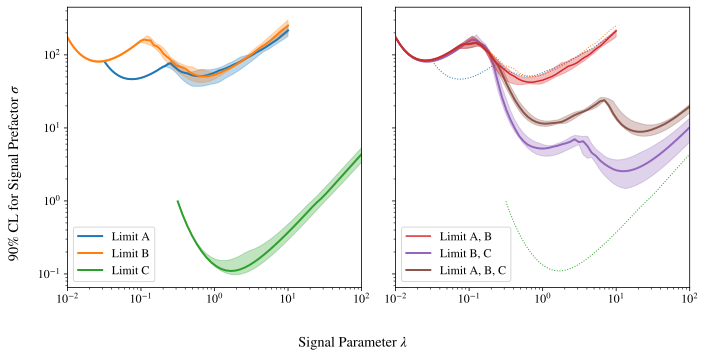

In [19]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].loglog(pars_alice, np.quantile(limit_alice, q=0.5, axis=0), label='Limit ' + NAMES[0], linewidth=2, color='C0')
axes[0].loglog(pars_bob, np.quantile(limit_bob, q=0.5, axis=0), label='Limit ' + NAMES[1], linewidth=2, color='C1')
axes[0].loglog(pars_carol, np.quantile(limit_carol, q=0.5, axis=0), label='Limit ' + NAMES[2], linewidth=2, color='C2')
axes[0].fill_between(pars_alice, y1=np.quantile(limit_alice, q=0.75, axis=0),
                    y2=np.quantile(limit_alice, q=0.25, axis=0), color='C0', alpha=0.3)
axes[0].fill_between(pars_bob, y1=np.quantile(limit_bob, q=0.75, axis=0),
                    y2=np.quantile(limit_bob, q=0.25, axis=0), color='C1', alpha=0.3)
axes[0].fill_between(pars_carol, y1=np.quantile(limit_carol, q=0.75, axis=0),
                    y2=np.quantile(limit_carol, q=0.25, axis=0), color='C2', alpha=0.3)
axes[0].legend(loc='lower left')

axes[1].loglog(pars_alice, np.quantile(limit_alice, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C0')
axes[1].loglog(pars_bob, np.quantile(limit_bob, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C1')
axes[1].loglog(pars_carol, np.quantile(limit_carol, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C2')
axes[1].loglog(pars_ab, np.quantile(limit_ab, q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1], color='C3', zorder=15)
axes[1].loglog(pars_bc, np.quantile(limit_bc, q=0.5, axis=0), label='Limit ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C4')
axes[1].loglog(pars_all, np.quantile(limit_all, q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C5')
axes[1].fill_between(pars_ab, y1=np.quantile(limit_ab, q=0.75, axis=0),
                    y2=np.quantile(limit_ab, q=0.25, axis=0), color='C3', alpha=0.3, zorder=15)
axes[1].fill_between(pars_bc, y1=np.quantile(limit_bc, q=0.75, axis=0),
                    y2=np.quantile(limit_bc, q=0.25, axis=0), color='C4', alpha=0.3)
axes[1].fill_between(pars_all, y1=np.quantile(limit_all, q=0.75, axis=0),
                    y2=np.quantile(limit_all, q=0.25, axis=0), color='C5', alpha=0.3)

axes[1].set_xlim(1e-2,1e2)
axes[1].legend(loc='lower left')

fig.supxlabel('Signal Parameter $\lambda$')
fig.supylabel('90% CL for Signal Prefactor $\sigma$')

plt.tight_layout()
plt.savefig('plots/yellin_limits.pdf')
plt.show()

We can see, that only in the regions where the limits are not background limited, the combined limit is better than the individual ones. In the background limited regions, the exclusion limit is roughly the average of the individual ones.

Done.